# Imports

In [7]:
import pathlib
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import cv2

from skimage import data, io, color
from matplotlib.colors import ListedColormap
from scipy import ndimage

%matplotlib inline

# Workflow for a single image

In [8]:
# Reading in a random first train image:

training_paths = pathlib.Path('./Datasets/stage1_train/').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[7]
im = imageio.imread(str(im_path))

# Taking a look at it inline

/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


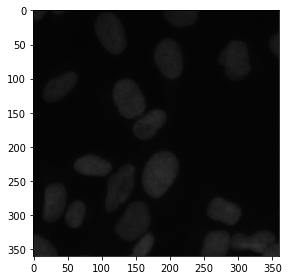

In [9]:
io.imshow(im)
plt.show()

# /// Trying the process with skimage

### // Dealing with color

The images in this dataset can be in RGB, RGBA and grayscale format, based on the "modality" in which they are acquired. For color images, there is a third dimension which encodes the "channel" (e.g. Red, Green, Blue). To make things simpler for our processing, I'm going to coerce all these images into grayscale using the `rgb2gray` function from scikit-image.

In [10]:
# Original image dimensions

print('Original image shape: {}'.format(im.shape))

# Coercing the image into grayscale format (if it's not already)

from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (360, 360, 4)
New image shape: (360, 360)


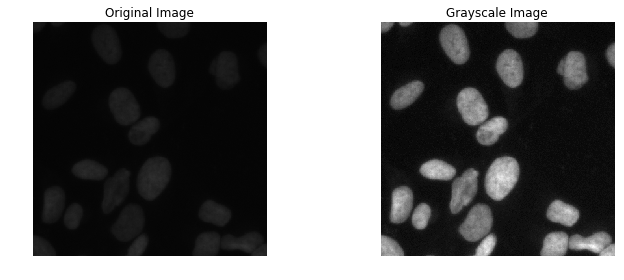

In [11]:
# Now, let's take a look at actually plotting that:

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.savefig('Converting to Grayscale.png', bbox_inches='tight', pad_inches=.5)
plt.show();

## Edge-based segmentation
First, we'll try to delineate the contours of the coins using edge-based segmentation. To do this, we first get the edges of features using the Canny edge-detector.

The steps of the algorithm are as follows:

- Smooth the image using a Gaussian with sigma width.
- Apply the horizontal and vertical Sobel operators to get the gradients within the image. The edge strength is the norm of the gradient.
- Thin potential edges to 1-pixel wide curves. First, find the normal to the edge at each point. This is done by looking at the signs and the relative magnitude of the X-Sobel and Y-Sobel to sort the points into 4 categories: horizontal, vertical, diagonal and antidiagonal. Then look in the normal and reverse directions to see if the values in either of those directions are greater than the point in question. Use interpolation to get a mix of points instead of picking the one that’s the closest to the normal.
- Perform a hysteresis thresholding: first label all points above the high threshold as edges. Then recursively label any point above the low threshold that is 8-connected to a labeled point as an edge.

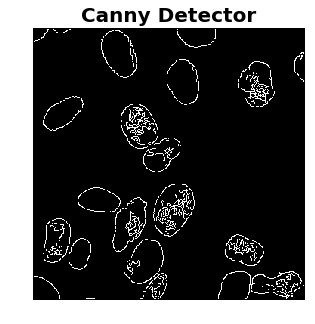

In [47]:
from skimage.feature import canny

edges = canny(im_gray, sigma=.01, low_threshold=.01, high_threshold=.1)

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Canny Detector', size = 20, weight = 'bold')
ax.axis('off')
plt.savefig('Canny Detector.png', bbox_inches='tight', pad_inches=.25)

### These contours are then filled using mathematical morphology.

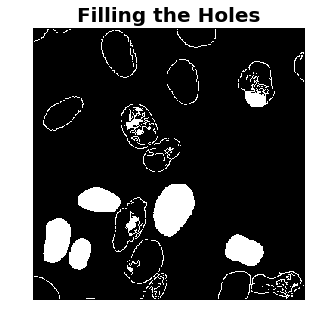

In [51]:
from scipy import ndimage as ndi

fill_cells = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(fill_cells, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Filling the Holes', size = 20, weight = 'bold')
ax.axis('off')
plt.savefig('Filling the Holes.png', bbox_inches='tight', pad_inches=.25)

### Small spurious objects are easily removed by setting a minimum size for valid objects.

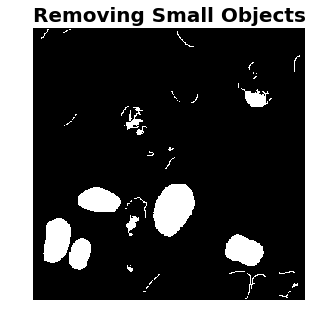

In [53]:
from skimage import morphology

cells_cleaned = morphology.remove_small_objects(fill_cells, 21)

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(cells_cleaned, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Removing Small Objects', size = 20, weight = 'bold')
ax.axis('off')
plt.savefig('Removing Small Objects.png', bbox_inches='tight', pad_inches=.25)

### * However, this method is not very robust, since contours that are not perfectly closed are not filled correctly, as is the case for the multiple unfilled nuclei above.

___
## Otsu's Method / Threshold

Or we can assume that there are two classes in the image: objects of interest and the background. Under this assumption, we would expect the data to fall into a bimodal distribution of intensities. If we found the best separation value, we could "mask" out the background data, then simply count the objects we're left with.

The most basic way we could find the threshold value would be to use a simple descriptive statistic, such as the mean or median. But there are other methods: the "Otsu" method is useful because it models the image as a bimodal distribution and finds the optimal separation value.

Otsu’s method calculates an “optimal” threshold (marked by a red line in the histogram below) by maximizing the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.

In [57]:
from skimage.filters import threshold_otsu

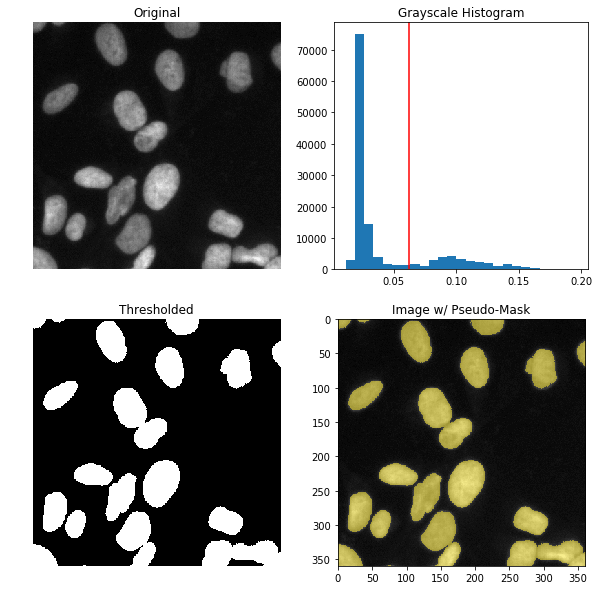

In [58]:
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# We also want to make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

# And now taking a look at all of those steps we've done so far visually:
fig, ax = plt.subplots(2,2, figsize=(10, 10))

ax[0,0].imshow(im_gray, cmap=plt.cm.gray)
ax[0,0].set_title('Original')

ax[0,1].hist(im_gray.ravel(), bins=25)
ax[0,1].set_title('Grayscale Histogram')
ax[0,1].axvline(thresh_val, color='r')

ax[1,0].imshow(mask, cmap=plt.cm.gray)
ax[1,0].set_title('Thresholded')

mask_for_display = np.where(mask, mask, np.nan)

ax[1,1].imshow(im_gray, cmap='gray')
ax[1,1].imshow(mask_for_display, cmap='viridis_r', alpha=0.5)
ax[1,1].set_title('Image w/ Pseudo-Mask')

for a in ax[:, 0]:
    a.axis('off')

plt.savefig('Otsu Threshold and Pseudo Mask.png', bbox_inches='tight', pad_inches=.25);
plt.show();


### Making actual masks for each object

For this contest, we need to get a separate mask for each nucleus. One way we can do this is by looking for all objects in the mask that are connected, and assign each of them a number using `ndimage.label`. Then, we can loop through each label_id and add it to an iterable, such as a list.

In [59]:
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 22 separate components / objects detected.


### Visualizing each unique mask

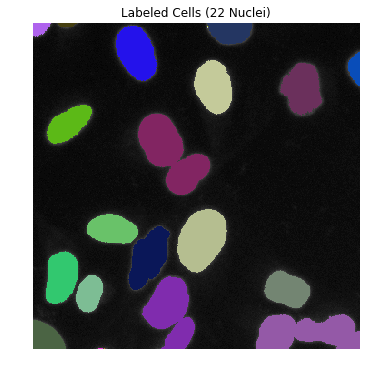

In [60]:
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.figure(figsize=(8,6))
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.savefig('Examining Initial Labels.png', bbox_inches='tight', pad_inches=.5)

plt.show();

### Problems already for this pretty simple image:
> - Our biggest issue is that we are seeing multiple instances where nuclei are being merged together that should not be.
> - We can see that specifically in the center, at center-bottom, and lower-right.
> - Also the count says that we have 22 nuclei, but I can only clearly count ~19 distinct colors. This means that some of them were too small to see (and probably incorrectly labeled).

### Using `ndimage.find_objects`, I can iterate through the masks, zooming in on the individual nuclei found to apply additional processing steps.  `find_objects` returns a list of the coordinate range for each labeled object in the image.

In [61]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small (i.e. getting rid of those individual pixels)
    if np.product(cell.shape) < 10: 
        print('Label {} is too small, setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerating the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small, setting to 0.
Label 5 is too small, setting to 0.
Label 20 is too small, setting to 0.
Label 21 is too small, setting to 0.
There are now 18 separate components / objects detected.


### Now I want to visually inspect some more and see if additional steps need to be taken

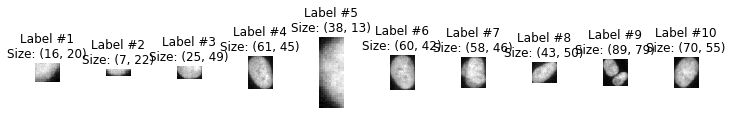

In [62]:
fig, axes = plt.subplots(1,10, figsize=(10,10))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:10]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

- Label #9 has the adjacent cell problem: the two cells are being considered the same object. 
- One thing that can be done here is to see whether we can shrink the mask to "open up" the differences between the cells. This is called mask erosion. 
- We can then re-dilate it to to recover the original proportions.

In [63]:
# Get the object indices, and perform a binary opening procedure

two_cell_indices = ndimage.find_objects(labels)[8]

cell_mask = mask[two_cell_indices]

cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=7) # Seems like 7 is going to be the smallest 
                                                                   # separation value I can get for now based on below

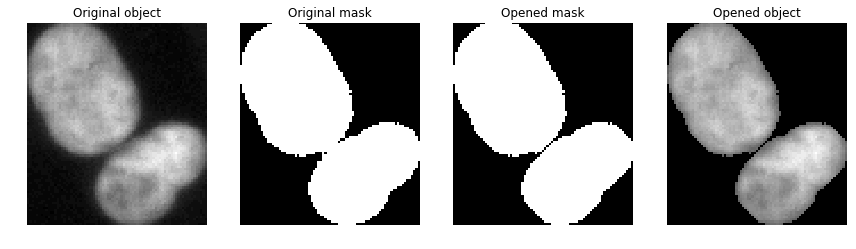

In [64]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')

axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')

axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')

axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.savefig('Binary Opening.png', bbox_inches='tight', pad_inches=.5)
plt.show()

### Convert each labeled object to Run Line Encoding

Finally, we need to encode each `label_mask` into a "run line encoded" string. Basically, we walk through the array, and when we find a pixel that is part of the mask, we index it and count how many subsequent pixels are also part of the mask. We repeat this each time we see new pixel start point.

I found a nice function to do RLE from Kaggle user Rakhlin's kernel, which I've copied here.

In [65]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 28440 1


## Combine it into a single function

Now that we've seen the basic steps to processing an image this way, we can combine it all into a single function. This function will take an image path, perform the processes outlined above, and spit out a dataframe with the RLE strings for each mask found.

We also create a wrapper function that will spit out a single DataFrame for all images in the dataset.

In [66]:
def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 23:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

## Generating a submission

In [67]:
%%time
testing = pathlib.Path('./Datasets/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission_basic.csv', index=None)

CPU times: user 28.7 s, sys: 7.26 s, total: 36 s
Wall time: 40.3 s


# /// Region-based segmentation with Sobel Elevation and watershed

In [68]:
import pathlib
import imageio
import numpy as np

from skimage import morphology
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage as ndi

# Glob the training data and load a single image path
training_paths = pathlib.Path('./Datasets/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])

Just looking at our same example image in the training set for now.

/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


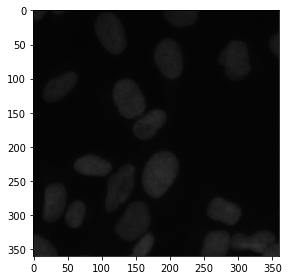

In [69]:
im_path = training_sorted[7]
img = imageio.imread(str(im_path))
io.imshow(img)

In [70]:
# Original image dimensions

print('Original image shape: {}'.format(im.shape))

# Coercing the image into grayscale format (if it's not already)

from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (360, 360, 4)
New image shape: (360, 360)


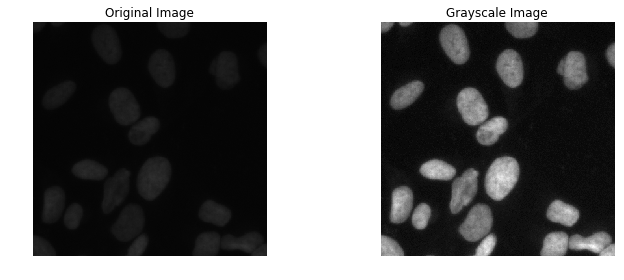

In [71]:
# Now, let's take a look at actually plotting that:

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.savefig('Converting to Grayscale.png', bbox_inches='tight', pad_inches=.5)
plt.show();

(-0.5, 359.5, 359.5, -0.5)

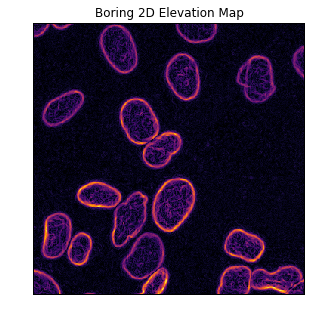

In [84]:
from skimage.filters import sobel, scharr

elevation_map = scharr(im_gray)

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(elevation_map, cmap='inferno', interpolation='nearest')
ax.set_title('Boring 2D Elevation Map')
ax.axis('off')

(-0.5, 359.5, 359.5, -0.5)

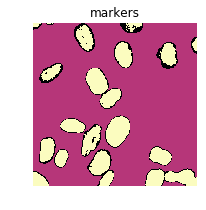

In [73]:
markers = np.zeros_like(im_gray)
markers[im_gray < .05] = 1
markers[im_gray > .08] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap='magma', interpolation='nearest')
ax.set_title('markers')
ax.axis('off')

(-0.5, 359.5, 359.5, -0.5)

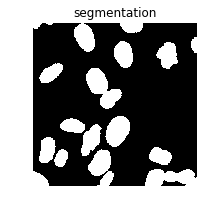

In [74]:
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')

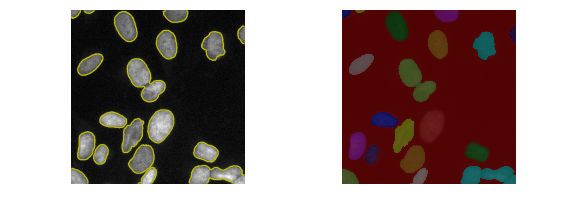

In [75]:
from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_cells, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_cells, image=im_gray)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(im_gray, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')

plt.tight_layout()